# Basic Models in TensorFlow 

## Review 
- TensorFlow separates definition of computations from their execution
    + Phase1: Assemble a graph
    + Phase2: Use a session to execute operations in the graph
- tf.constant and tf.Variable
    + Constant values are stored in the graph definition 
    + Sessions allocate memory to store variable values 
- tf.placeholder and feed_dict
    + Feed values into placeholders with a dictionary(feed_dict)
    + Easy to use but poor performance 
- Avoid lazy loading 
    1. Separate the assembling of graph and execution ops
    2. Use Python attribute to ensure a function is only loaded the first time it's called

## Linear regression in TensorFlow
- Model the linear relationship between
    + dependent variable Y, explanatory variables X 
    + Find a linear relationship between X and Y to predict Y from X 
- Inference: Y_predicted = w * X +b

### Linear Regression with MSE loss 

#### Setup 

In [24]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.11.0


#### Load and Pre-process data 

In [27]:
# Read in data
data = pd.read_table('../data/birth_life_2010.txt')
data.head()

,Country,Birth rate,Life expectancy
0,Vietnam,1.822,74.828244
1,Vanuatu,3.869,70.819488
2,Tonga,3.911,72.150659
3,Timor-Leste,5.578,61.999854
4,Thailand,1.579,73.927659


In [30]:
x = data.loc[:, 'Birth rate'].values
y = data.loc[:, 'Life expectancy'].values
print(x.shape, y.shape)

(190,) (190,)


In [32]:
# Split train and validation 
# 190개에서 0.7= 133개 선택(idex)
tr_indices = np.random.choice(range(x.shape[0]), size = int(x.shape[0] * .7), replace=False)
print('tr_indices: {}'.format(tr_indices))

tr_indices: [ 96 160  24 142 148 151 171 124 147 150  70 157 134  49  86  35  98 119
  29  31  16  23 180 128  40  66   9  52  47 115 135 177 162  85  53  44
  15 146 166 100  62  55 132  32  64  18  94 110 125 102   1  36  56  22
 175 144 101  51  83 131  80 168 123 176  34  88  79   0 113  25  57  17
 169 152 187  97 163 114  50  10  95  30  46 153 104  76  63  58 112 103
 158  59   3  67  21 139 188   4  39  77  33 182 155  14 164   7 141  45
 109 172  54 149  60  84 122 120 127  91  27  48  61  72  89  99  92 143
  42 140 137 179   8 159 167]


In [47]:
x_tr = x[tr_indices]
y_tr = y[tr_indices]

x_val = np.delete(x, tr_indices, axis=0)
y_val = np.delete(y, tr_indices, axis=0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(133,) (133,)
(57,) (57,)


#### Define the graph of Simple Linear Regression 

In [36]:
# Create placeholders for inputs(X, birth rate) and labels(Y, life expectancy)
X = tf.placeholder(dtype=tf.float32, shape=[None], name='input')
Y = tf.placeholder(dtype=tf.float32, shape=[None], name='label')

# Createweight and bias
w = tf.get_variable(name='weight', initializer=tf.constant(.0))
b = tf.get_variable(name='bias', initializer=tf.constant(.0))

# Inference: Construct model to predict Y
y_predicted = X * w + b

# Specify loss function
# Use the square error as a loss function
mse_loss = tf.reduce_mean(tf.square(Y - y_predicted))
mse_loss_summ = tf.summary.scalar(name='mse_loss', tensor=mse_loss)

# Create optimizer
# Using gradient descent with learning rate of 0.01 to minimize loss 
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(mse_loss)

#### Training 
1. Initialize variables 
2. Run optimizer

In [37]:
epochs = 100
batch_size = 8
total_step = int(x.shape[0] / batch_size)
print(total_step)

23


In [38]:
train_writer = tf.summary.FileWriter(logdir='../graphs/lec03/linreg_mse_tf_placeholder/train',
                                    graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir='../graphs/lec03/linreg_mse_tf_placeholder/val',
                                  graph=tf.get_default_graph())

In [48]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):#epoch = 100
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):#total_step = 23 
        # batch_indices = 133개 중에 8개씩 
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                        size=batch_size, replace=False)
        val_indices = np.random.choice(range(x_val.shape[0]),
                                      size=batch_size, replace=False)
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches=[training_op, mse_loss],
                             feed_dict={X: batch_xs, Y: batch_ys})
        tr_loss_summ = sess.run(mse_loss_summ, feed_dict={X: batch_xs, Y: batch_ys})
        
        val_loss, val_loss_summ = sess.run(fetches=[mse_loss, mse_loss_summ],
                                         feed_dict={X: val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step=epoch)
    val_writer.add_summary(val_loss_summ, global_step=epoch)
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss: {:.2f}, val_loss: {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss: 1805.22, val_loss: 1594.06
epoch :  10, tr_loss: 246.55, val_loss: 248.90
epoch :  20, tr_loss: 78.49, val_loss: 68.58
epoch :  30, tr_loss: 42.35, val_loss: 37.90
epoch :  40, tr_loss: 38.79, val_loss: 26.82
epoch :  50, tr_loss: 31.65, val_loss: 30.76
epoch :  60, tr_loss: 26.69, val_loss: 20.08
epoch :  70, tr_loss: 32.16, val_loss: 17.91
epoch :  80, tr_loss: 31.50, val_loss: 25.25
epoch :  90, tr_loss: 32.19, val_loss: 25.47


#### Visualization

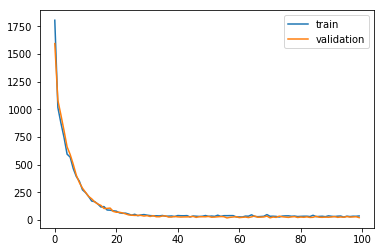

In [50]:
plt.plot(tr_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.legend()

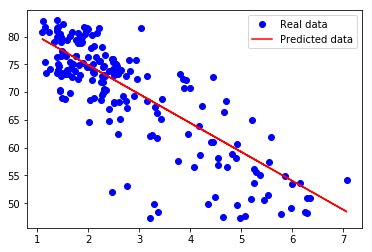

In [53]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()